# Advanced Geocomputing - MVP 1
### Eric Gibson

## Problem

Sky islands hold species of animals which cannot be found anywhere else on Earth and act as "natural laboratories", enabling complex ecological phenomena to be monitored comparatively easily. Unfortunately, these regions are highly susceptible to climate change and are at high risk of disappearing within the next few decades due to several factors, including desertification, wildfires, and human development.

## Solution

This project seeks to determine species population growth, decline, and movement, among other population dynamics, over time based on current and future climate outlooks to predict if, when, and how species may go extinct, move, or even grow through an Individual-Based Model. This model uses species preferences to determine areas where a single individual of the species (occurrence in this case) would move to and avoid while also implementing how the species would reproduce and competitively interact with one another. It is also important to note that each individual squirrel will have its own unique preferences and some randomness will be implemented, as most species are fairly complex.

## Challenge

The greatest challenge in creating this model is the actual Individual-Based Model itself. Not only will this be difficult code to brainstorm and create, it will also likely use a lot of computing power since the model influences every single point in the occurrences feature class.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, Polygon
import requests
import os
import io
import zipfile
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio import Affine
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import random
import numpy as np
import pandas as pd
import json
import geojson
import contextily as cx
import time
from datetime import timedelta
from scipy import stats
import matplotlib.colors as colors

## Define a function to add and unzip a file to a local directory

In [2]:
def get_and_unzip(url,directory):

# Get the United States boundary shapefile from the US Census
    url = url
    US_boundary = requests.get(url)
    
    # Unzip the file to a local folder
    with zipfile.ZipFile(io.BytesIO(US_boundary.content)) as usZip:
        usZip.extractall(directory)

In [6]:
# Get US boundary shapefile from the US census
get_and_unzip('http://www.cec.org/files/atlas_layers/0_reference/0_01_political_boundaries/politicalboundaries_shapefile.zip',r'C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\Boundaries')

## Create a sky islands study area boundary

In [3]:
# Create a sky islands boundary to clip by from the North America shapefile
clipCoords = [[-103.25,26.5],[-110.6,26.5],[-114.45,31.3],[-114.45,37.1],[-103.25,37.1]]

# Create Polygon object
clipGeom = Polygon(clipCoords)

# Create a GDF from Polygon information
clipGeom_gdf = gpd.GeoDataFrame([1], geometry = [clipGeom], crs = 'EPSG:4326')

## Create functions for creating a quick plot and converting a GeoDataFrame to a GeoJSON

In [4]:
# Create a function for create a figure
def create_quick_plot(features,figsize,extent,outFile=None):

    # Convert features to EPSG:3857 for Web Mercator
    features3857 = features[0][0].to_crs(epsg = 3857)

    # Create the plot
    fig, ax = plt.subplots(figsize = figsize)
    
    # Iterate through features
    for f in features:

        # Convert features to EPSG:3857 for Web Mercator
        f3857 = f[0].to_crs(epsg = 3857)

        # Add features in "features" to the plot
        f3857.plot(ax = ax, color = f[2], edgecolor = 'black', alpha = f[3], label = f[1])

    # Set the user-defined extent of the map
    ax.set_xlim([extent[0],extent[1]])
    ax.set_ylim([extent[2],extent[3]])

    # Add a basemap using contextily
    cx.add_basemap(ax, source = cx.providers.OpenStreetMap.Mapnik)

    # Save the plot if necessary
    if outFile is not None:
        plt.savefig(outFile, dpi = 500, bbox_inches = 'tight')

In [5]:
# Establish a function to save GDFs
def gdf_to_gJ(gdf,outGJ):

    # Save siBoundary as GeoJSON
    gJ_string = gdf.to_json()
    
    # Write GeoJSON string to file
    with open(outGJ,'w') as f:
        f.write(gJ_string)

## Add the North America boundaries and add to map with the study area polygon

EPSG:4326


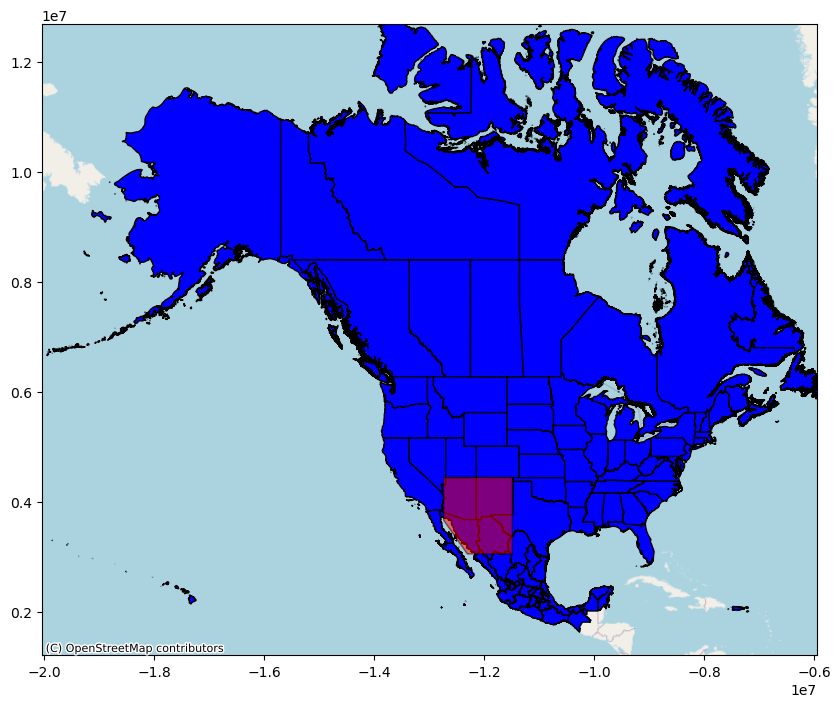

In [6]:
# Use gpd.read_file() function to read both shapefiles separately
naBoundaries = gpd.read_file(r"C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\Boundaries\NA Political Divisions Polygons.shp")

# CHange coordinate system to WGS84
naBoundaries_WGS84 = naBoundaries.to_crs(epsg=4326)
print(naBoundaries_WGS84.crs)

# Create the plot
create_quick_plot(
    features = [[naBoundaries_WGS84,'North American Boundaries','blue',1],[clipGeom_gdf,'Clip Geometry','red',0.5]],
    figsize = (10,10),
    extent = [-20037508.342789,-5948635.289266,1213208.512942,12679985.748171]
)

### IMPORTANT! Run below code only if it's your first run

In [64]:
# Perform a dissolve to merge all polygon features into one
naBoundary = naBoundaries_WGS84.dissolve()

# Clip the created polygon by the naBoundary
siBoundary = gpd.clip(clipGeom_gdf,naBoundary)

# Convert GDF to GeoJSON
gdf_to_gJ(siBoundary,'siBoundary_gJ.geojson')

### Run the code below on subsequent runs

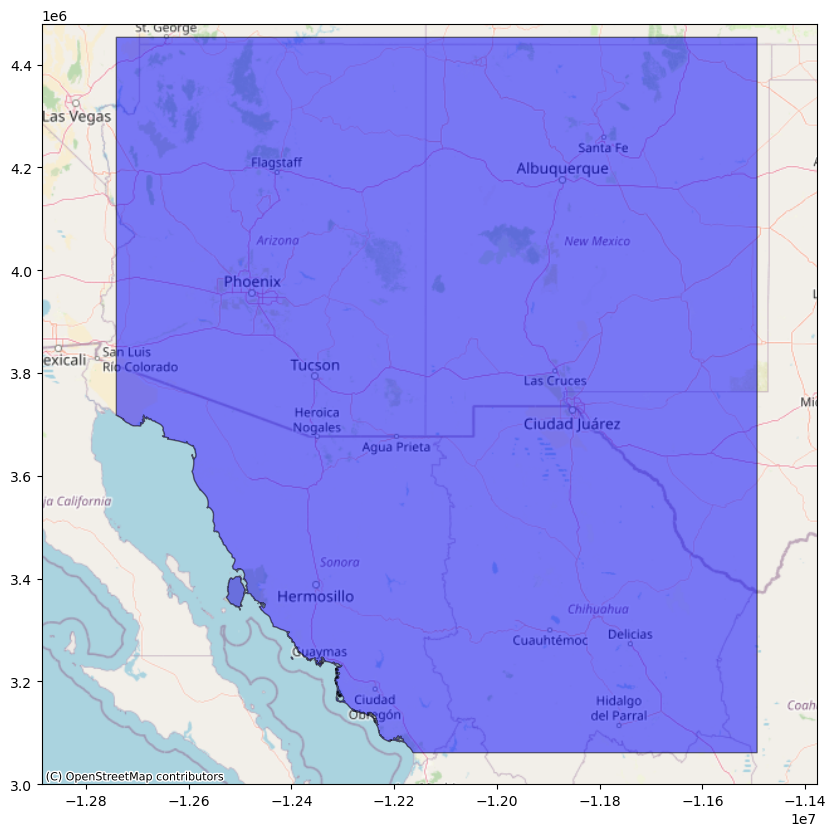

In [6]:
# Run this code if it's after your first run

# Add GeoJSON to GDF
siBoundary = gpd.read_file('siBoundary_gJ.geojson')

# Create variable for study area extent
studyArea = [-12885448.480202,-11377498.786192,3000000,4478598.361285]

# Create a simple plot
create_quick_plot(
    features = [[siBoundary,'Sky Islands Boundary','blue',0.5]],
    figsize = (10,10),
    extent = studyArea
)

### Create a function to easily convert a CSV with lats and lons to a GDF
- This is done so the code can be changed easily if different species data is needed to perform the accuracy assessment

In [7]:
# Define a function to convert a .csv file with coordinate information into a geodataframe
def convertCSV(csvFile,latField,lonField):

    # Use .read_csv() function to convert a .csv file to a DF
    df = pd.read_csv(csvFile)

    # Create a geometry column using the lat and lon fields
    geom = [Point(xy) for xy in zip(df[lonField],df[latField])]

    # Create GDF from lats and lons in DF
    gdf = gpd.GeoDataFrame(df, geometry = geom)

    # Make sure GDF is WGS84
    gdf.set_crs(epsg = 4326, inplace = True)

    # Return the GDF
    return gdf

C:\Users\ericg\AppData\Local\Temp\ipykernel_27180\3062032715.py:5: DtypeWarning: Columns (12,18,25,28,31,42,44,54,56,57,77,78,105,117,119,121,125,129,133,147,149,150,151,152,153,173,178,204,210,220,221) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvFile)


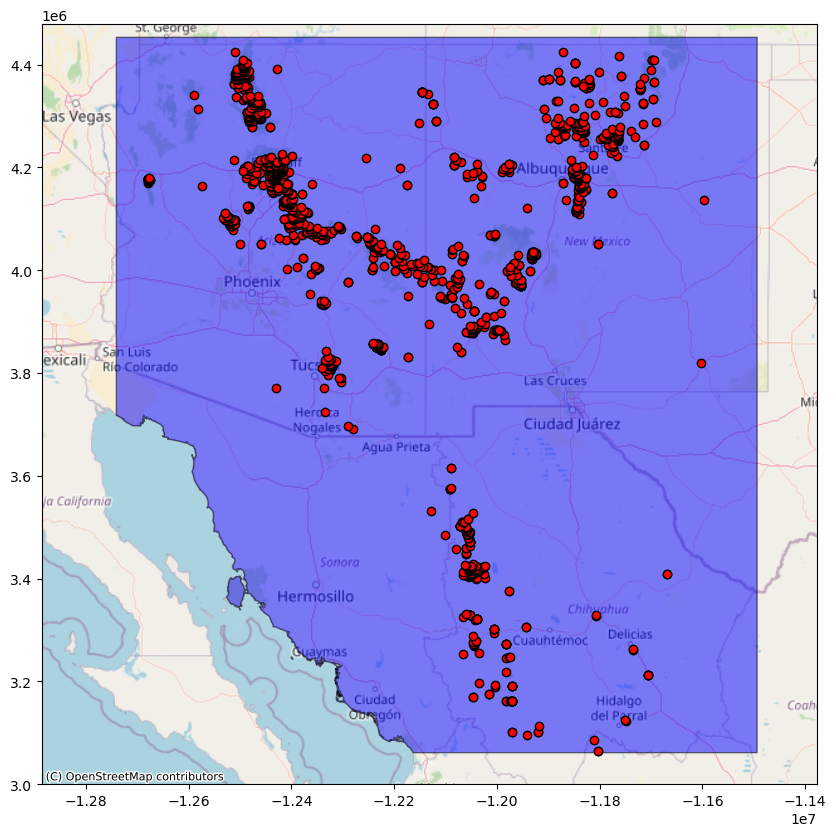

In [8]:
# Run the function
abertsSquirrel = convertCSV(r"C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\01_Species Data\Abert_sSquirrel\All Data\Abert's Squirrel Data.csv",'decimalLatitude','decimalLongitude')

# Clip the squirrel occurrences with the siBoundary
siAberts = gpd.clip(abertsSquirrel,siBoundary)

# Generate simple map with points for aberts squirrel
create_quick_plot(
    features = [[siBoundary,'Sky Islands Boundary','blue',0.5],[siAberts,"Aberts Squirrel Occurences",'red',1]],
    figsize = (10,10),
    extent = studyArea,
    outFile = "Abert's_Squirrel_Study_Area.png"
)

### Run below code if it's your first run

In [14]:
# Run this cell if a geojson for the Aberts Squirrel has not been created
gdf_to_gJ(siAberts,'siAberts.geojson')

### Run below code on subsequent runs

In [9]:
# Run this cell for subsequent runs
siAberts = gpd.read_file('siAberts.geojson')

### Create a function for generating random points within a polygon

In [10]:
# Define a function which creates random points within a polygon
def genRandPts(feature,ptNum):

    # Find bounds of polygon
    bBox = feature.total_bounds

    # Create empty list for adding point coordinates into
    points = []

    # Create while loop that continues as long as the length of the "points" list is less than the number of points specified by the user
    while len(points) < ptNum:

        # Create a random point by selecting random latitude and longitude values within the bounds of the polygon
        randPt = Point(np.random.uniform(float(bBox[0]), float(bBox[2])), np.random.uniform(float(bBox[1]), float(bBox[3])))

        # If the polygon contains this random point, at it to the "points" list
        if randPt.within(feature.geometry.iloc[0]) is True:
            points.append(randPt)

    # Create a GDF from point geometry
    randPts_GDF = gpd.GeoDataFrame(geometry = points, crs = 'EPSG:4326')

    # Return GDF
    return randPts_GDF

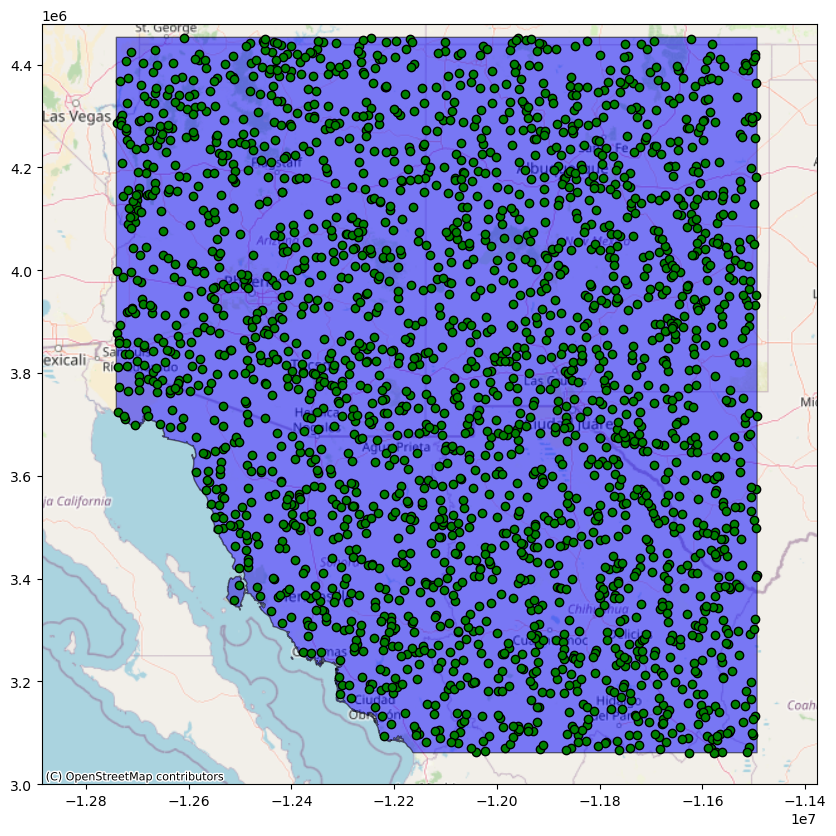

In [11]:
# Test the random points function

# Find number of rows in siAberts GDF
randNum = len(siAberts)

# Create a variable with randPts
randPts = genRandPts(siBoundary,randNum)

create_quick_plot(
    features = [[siBoundary,'Sky Islands Boundary','blue',0.5],[randPts,'Random Points','green',1]],
    figsize = (10,10),
    extent = studyArea,
    outFile = 'Study_Area_Random_Points_Example.png'
)

### Create a function to easily bring in rasters from a folder
- This will make it easier to create the final precipitation and temperature rasters which contain average monthly data

In [12]:
def getRastersFromFolder(folder):

    # Set variable for the folder path
    folder = folder
    
    # Set a variable for the raster list
    fileList = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    # Create empty raster list
    rastList = []
    
    # If it is a .tif file, add it to the rastList
    for file in fileList:
        if file[-4:] == '.tif':
            rastList.append(file)

    # Return file list
    return rastList

### Create several functions for raster calculations

- update_metadata() - Adds metadata from a previous raster to the newly created raster
- convert_raster_to_float() - Issues arose with rasters using cells with an "object" class, this converts the raster values to float
- mergeRasters() - Merges multiple rasters into one
- reprojectRaster() - Reprojects raster to a different coordinate system
- create_studyArea_raster() - Clips raster to fit the project study area
- resample() - Uses the bilinear resampling method to change the number of cells in a raster
- reclassify() - Change ranges of values to a specific value in a raster
- raster_calculator() - Allows multiple functions to be performed on one or multiple rasters
- align_rasters() - Rasters can only be calculated togther if they have the same array length, so this function aligns the cells with each other

In [13]:
# Define a function to add metadata from original raster to new raster
def update_metadata(src, height, width, transform, crs = None):

    # If crs = None
    if crs is None:
    
        # Update metadata to reflect new dimensions, resolution, and transform
        new_meta = src.meta.copy()
        new_meta.update({
            'driver': 'GTiff',
            'height': height,
            'width': width,
            'transform': transform
        })

    # Else
    else:

        # Update metadata to reflect new dimensions, resolution, crs, and transform
        new_meta = src.meta.copy()
        new_meta.update({
            'driver': 'GTiff',
            'crs': crs,
            'height': height,
            'width': width,
            'transform': transform
        })

    return new_meta

# Define a function to convert the raster values to float
def convert_raster_to_float(inRaster, outRaster):
    
    # Open the input raster file
    with rasterio.open(inRaster) as src:
        
        # Read the data from the first band
        data = src.read(1)
        
        # Check for non-numeric values and handle them
        def safe_float_convert(val):
            try:
                return float(val)

            # Replace invalid values with NaN
            except (ValueError, TypeError):
                return np.nan

        # Vectorize the conversion function
        vectorized_convert = np.vectorize(safe_float_convert)
        
        # Apply the conversion
        cleaned_data = vectorized_convert(data)
        
        # Convert cleaned data to float32
        float_data = cleaned_data.astype(np.float32)
        
        # Update metadata for the new file, making sure dtype is float32
        meta = src.meta.copy()
        meta.update(dtype=rasterio.float32)
        
        # Write the converted float data to a new raster file
        with rasterio.open(outRaster, 'w', **meta) as dst:
            dst.write(float_data, 1)

# Define a function to merge rasters
def mergeRasters(rastList,outName):

    # Create a list to create a mosaic
    rast_to_mosaic = []

    # Iterate through source rasters
    for rast in rastList:

        # Open with rasterio
        src = rasterio.open(rast)

    # Append src to rast_to_mosaic list
    rast_to_mosaic.append(src)

    # Merge rasters in list with merge() function
    mosaic, out_transform = merge(rast_to_mosaic)

    # Copy metadata and add to merged raster
    out_meta = update_metadata(src, mosaic.shape[1], mosaic.shape[2], out_transform)

    # Save the merged raster
    with rasterio.open(outName,'w',**out_meta) as dest:
        dest.write(mosaic)

    return mosaic

# Define a function to reproject rasters
def reprojectRaster(inRaster, outRaster, crs):

    # Open source raster
    with rasterio.open(inRaster) as src:

        # Use calculate_default_transform function to get the correct projection
        transform, width, height = calculate_default_transform(
            src.crs, crs, src.width, src.height, *src.bounds)

        # Copy metadata into a variable
        kwargs = update_metadata(src, height, width, transform, crs)

        # Copy all information into the user-defined output raster
        with rasterio.open(outRaster, 'w', **kwargs) as dst:

            # For all cells in the source raster, reproject
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.nearest)

# Define a function for adding and clipping a raster by the study area
def create_studyArea_raster(raster,studyArea,outName):

    # Add temperature, precipitation, elevation, and NDVI rasters to project
    with rasterio.open(raster) as src:

        # Extract geometry(ies) from GDF
        geom = [studyArea.geometry[0].__geo_interface__]

        # Clip raster with mask function
        out_image, out_transform = mask(src, geom, crop = True)

        # Copy metadata and add to clipped raster
        out_meta = update_metadata(src, out_image.shape[1], out_image.shape[2], out_transform)

        # Add raster to a file
        with rasterio.open(outName, 'w', **out_meta) as dst:
            dst.write(out_image[0], 1)

    return out_image[0]

# Create a function to resample raster so the cells match
def resample(inRaster, outRaster, scaleFactor):
  
    # Open the source raster
    with rasterio.open(inRaster) as src:
        # Calculate the new shape (number of rows and columns)
        new_width = int(src.width * scaleFactor)
        new_height = int(src.height * scaleFactor)

        # Calculate the new transform (affine transformation)
        new_transform = src.transform * src.transform.scale(
            (src.width / new_width),
            (src.height / new_height)
        )

        # Update metadata for the outRaster with the inRaster
        out_meta = update_metadata(src, new_height, new_width, new_transform, crs = None)
        
        # Create the output raster file
        with rasterio.open(outRaster, 'w', **out_meta) as dst:
            # Iterate through each band and resample it
            for i in range(1, src.count + 1):
                resampled_band = src.read(
                    i,
                    out_shape=(new_height, new_width),
                    resampling=Resampling.bilinear  # You can change this to other methods like Resampling.nearest
                )
                
                # Write the resampled band to the output raster
                dst.write(resampled_band, i)

    # Return raster
    return resampled_band

# Define a function to remove a dimension
def remDimension(inRaster, outRaster):
    
    # Open the inRaster file
    with rasterio.open(inRaster) as src:
        
        # Read the data
        data = src.read()
        
        # Squeeze the data (remove single-dimensional entries)
        squeezed = np.squeeze(data)
        
        # If squeezing resulted in a 2D array, update metadata for a single band
        out_meta = src.meta.copy()
        
        # If data was squeezed from (1, height, width) to (height, width),
        # we need to update the count of bands to 1 (because it's 2D now)
        if squeezed.ndim == 2:
            out_meta.update({
                "count": 1,  # Single band
            })
        
        # Save the squeezed data to a new raster file
        with rasterio.open(outRaster, 'w', **out_meta) as dest:
            
            # Write the squeezed data, if it's now 2D write it as band 1
            dest.write(squeezed, 1)

    # Return the squeezed raster if necessary
    return squeezed

# Define a function to reclassify the rasters
def reclassify(inRaster, outRaster, reclassMap):
    
    # Open raster with rasterio
    raster = rasterio.open(inRaster)

    # Make a variable equivalent to the data within the raster
    data = raster.read()

    # Make a copy of the data
    copy = data.copy()

    # Iterate through each mapping
    for mapping in reclassMap:
    
        # Create a list of data values
        copy[np.where((copy >= mapping[0]) & (copy <= mapping[1]))] = mapping[2]

    # Create an output raster
    with rasterio.open(outRaster,'w',
                       driver = raster.driver,
                       height = raster.height,
                       width = raster.width,
                       count = raster.count,
                       crs = raster.crs,
                       transform = raster.transform,
                       dtype = data.dtype
                      ) as dst:
        dst.write(copy)

    return copy

# Define a function to create a raster calculator
def rasterCalculator(input_rasters, output_raster, operation, factor=None):
    
    if len(input_rasters) < 1:
        raise ValueError("At least one input raster must be provided.")
    
    # Open the first raster to get the metadata and base data
    with rasterio.open(input_rasters[0]) as src:
        base_data = src.read(1).astype(np.float32)  # Read the first band as float32
        meta = src.meta.copy()  # Copy the metadata
        
    # If factor is provided, perform operation between raster and the factor
    if factor is not None:
        if operation == "add":
            result_data = base_data + factor
        elif operation == "subtract":
            result_data = base_data - factor
        elif operation == "multiply":
            result_data = base_data * factor
        elif operation == "divide":
            result_data = np.divide(base_data, factor, where=factor != 0)
        else:
            raise ValueError(f"Unsupported operation: {operation}")
    
    else:
        # If no factor is provided, perform the operation between rasters
        if len(input_rasters) == 1:
            raise ValueError("At least two rasters are required for operations between rasters.")
        
        # Initialize result data with the first raster's data
        result_data = base_data

        # Special handling for 'average'
        if operation == "average":
            result_data = result_data / len(input_rasters)
        
        for raster_path in input_rasters[1:]:
            with rasterio.open(raster_path) as src2:
                data2 = src2.read(1).astype(np.float32)
                
                # Perform the specified operation element-wise between rasters
                if operation == "add":
                    result_data += data2
                elif operation == "subtract":
                    result_data -= data2
                elif operation == "multiply":
                    result_data *= data2
                elif operation == "divide":
                    result_data = np.divide(result_data, data2, where=data2 != 0)
                    
    # Write the result to a new raster file
    meta.update(dtype=rasterio.float32)  # Ensure output is float32
    with rasterio.open(output_raster, 'w', **meta) as dst:
        dst.write(result_data.astype(rasterio.float32), 1)

    return result_data

- create_rasters() - Takes rasters from the unzipped folders and combines them (finds the average values for all temperature and precipitation rasters)

In [14]:
def create_rasters(folder,operation,outFile):

    # Add rasters in a to a list 
    rasts = getRastersFromFolder(folder)
    print(rasts)

    # Create a variable with an empty value and an empty list
    month = 0
    fileList = []

    # Iterate through each raster
    for rast in rasts:
        month += 1

        # Clip by study area
        create_studyArea_raster(rast, siBoundary, f'si{month}.tif')
        fileList.append(f'si{month}.tif')

    # Calculate rasters
    rasterCalculator(fileList, outFile, operation)

### Create temperature raster

In [14]:
# Create temp raster
tempRast = create_rasters(r'C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\Temperature\wc2.1_30s_tavg','average','tempRast1.tif')

# Resample temp raster to make it the same size as the NDVI raster
tempRast_resample = resample('tempRast1.tif','tempRast_resample.tif',4)

['C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_01.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_02.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_03.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_04.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_05.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_06.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_07.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Temperature\\wc2.1_30s_tavg\\wc2.1_30s_tavg_08.tif', 'C:\\Users\\ericg\\OneD

### Create precipitation raster

In [15]:
# Create precip raster
precRast = create_rasters(r'C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\Precipitation\wc2.1_30s_prec','average','precRast1.tif')

# Resample temp raster to make it the same size as the NDVI raster
precRast_resample = resample('precRast1.tif','precRast_resample.tif',4)

['C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_01.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_02.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_03.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_04.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_05.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_06.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_07.tif', 'C:\\Users\\ericg\\OneDrive\\Documents\\Evolution Model Sky Islands\\Precipitation\\wc2.1_30s_prec\\wc2.1_30s_prec_08.tif', 'C:\\Us

### Create vegetation raster

In [16]:
# Reproject rasters
reprojectRaster(r"C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\Vegetation\US_eVSH_NDVI.2024.212-218.3KM.COMPRES.001.2024221185254\US_eVSH_NDVI.2024.212-218.3KM.VI_NDVI.001.2024221184447.tif", 'usNDVI_wgs84.tif', 'epsg:4326')
reprojectRaster(r"C:\Users\ericg\OneDrive\Documents\Evolution Model Sky Islands\Vegetation\CC_eVSH_NDVI.2024.208-218.3KM.COMPRES.001.2024221161726\CC_eVSH_NDVI.2024.208-218.3KM.VI_NDVI.001.2024221160117.tif", 'mxNDVI_wgs84.tif', 'epsg:4326')

# Lastly, Create study area raster for NDVI
usNDVI_study = create_studyArea_raster('usNDVI_wgs84.tif', siBoundary, 'usNDVI_study.tif')
mxNDVI_study = create_studyArea_raster('mxNDVI_wgs84.tif', siBoundary, 'mxNDVI_study.tif')

# Create list with rasters
rastList = ['mxNDVI_study.tif','usNDVI_study.tif']

# Merge US and MX raster
mergeNDVI = mergeRasters(rastList,'mergeNDVI.tif')

# Squeeze the raster to a 2D array
squeezedNDVI = remDimension('mergeNDVI.tif','squeezedNDVI.tif')

## Create Sky Islands Model - Today

In [14]:
# Firstly, convert all rasters to float
convert_raster_to_float('tempRast1.tif', 'siTemp_float.tif')
convert_raster_to_float('precRast1.tif', 'siPrec_float.tif')
convert_raster_to_float('squeezedNDVI.tif', 'siNDVI_float.tif')

# Secondly, resample NDVI raster so it matches temp and prec rasters
# Find the extent difference (prec or temp raster extent / NDVI raster extent) and resample based on that

# Create a list with the temp/prec raster and NDVI raster
resampleList = ['siTemp_float.tif','squeezedNDVI.tif']

# Create empty list
widthsList = []

# Iterate through resampleList
for rast in resampleList:

    # Open temperature raster
    with rasterio.open(rast) as src:
    
        # Find the width
        numCol = src.height

    # Add width value to widthsList
    widthsList.append(numCol)

# Set a variable equal to the temp raster width / the NDVI raster width
NDVI_scaleFactor = widthsList[0]/widthsList[1]

# Resample
ndviResample = resample('siNDVI_float.tif', 'siNDVI_res.tif', NDVI_scaleFactor)

# Thirdly, reclassify rasters
siTemp_reclass = reclassify('siTemp_float.tif', 'siTemp_reclass.tif', [[-100,-0.5,5],[-0.5,0,4],[0,0.5,3],[0.5,1,2],[1,1.5,1]])
siPrec_reclass = reclassify('siPrec_float.tif', 'siPrec_reclass.tif', [[-5,1,1],[1,3.5,2],[3.5,4,3],[4,4.5,8],[4.5,50,10]])
siNDVI_reclass = reclassify('siNDVI_res.tif', 'siNDVI_reclass.tif', [[-2000,1000,1],[1000,3000,2],[3000,5000,3],[5000,7000,4],[7000,10000,5]])

# Next, create a list of reclassified rasters
reclassList = ['siTemp_reclass.tif', 'siPrec_reclass.tif','siNDVI_reclass.tif']

# Finally, multiply rasters using the raster calculator
siRaster = rasterCalculator(reclassList, 'siRast.tif', 'multiply')

C:\Users\ericg\AppData\Local\Temp\ipykernel_888572\1737528098.py:284: RuntimeWarning: overflow encountered in multiply
  result_data *= data2


## Create Sky Islands Model - 50 Years

In [5]:
# Firstly, convert all rasters to float
convert_raster_to_float('tempRast1.tif', 'siTemp_float.tif')
convert_raster_to_float('precRast1.tif', 'siPrec_float.tif')
convert_raster_to_float('squeezedNDVI.tif', 'siNDVI_float.tif')

# Secondly, resample NDVI raster so it matches temp and prec rasters
# Find the extent difference (prec or temp raster extent / NDVI raster extent) and resample based on that

# Create a list with the temp/prec raster and NDVI raster
resampleList = ['siTemp_float.tif','squeezedNDVI.tif']

# Create empty list
widthsList = []

# Iterate through resampleList
for rast in resampleList:

    # Open temperature raster
    with rasterio.open(rast) as src:
    
        # Find the width
        numCol = src.height

    # Add width value to widthsList
    widthsList.append(numCol)

# Set a variable equal to the temp raster width / the NDVI raster width
NDVI_scaleFactor = widthsList[0]/widthsList[1]

# Resample
ndviResample = resample('siNDVI_float.tif', 'siNDVI_res.tif', NDVI_scaleFactor)

# Thirdly, reclassify rasters
siTemp_reclass = reclassify('siTemp_float.tif', 'siTemp_reclass.tif', [[-100,-0.5 - 0.1,5],[-0.5 - 0.1,0 - 0.1,4],[0 - 0.1,0.5 - 0.1,3],[0.5 - 0.1,1 - 0.1,2],[1 - 0.1,1.5 - 0.1,1]])
siPrec_reclass = reclassify('siPrec_float.tif', 'siPrec_reclass.tif', [[-5,1 - (0.395 * 1),1],[1 + (0.395 * 1),3.5 + (0.395 * 3.5),2],[3.5 + (0.395 * 3.5),4 + (0.395 * 4),3],[4 + (0.395 * 4),4.5 + (0.395 * 4.5),8],[4.5 + (0.395 * 4.5),50,10]])
siNDVI_reclass = reclassify('siNDVI_res.tif', 'siNDVI_reclass.tif', [[-2000,1000,1],[1000,3000,2],[3000,5000,3],[5000,7000,4],[7000,10000,5]])

# Next, create a list of reclassified rasters
reclassList = ['siTemp_reclass.tif', 'siPrec_reclass.tif','siNDVI_reclass.tif']

# Finally, multiply rasters using the raster calculator
siRaster = rasterCalculator(reclassList, 'siRast_50years.tif', 'multiply')

C:\Users\ericg\AppData\Local\Temp\ipykernel_888412\1737528098.py:284: RuntimeWarning: overflow encountered in multiply
  result_data *= data2


## Create Sky Islands Model - 100 Years

In [8]:
# Firstly, convert all rasters to float
convert_raster_to_float('tempRast1.tif', 'siTemp_float.tif')
convert_raster_to_float('precRast1.tif', 'siPrec_float.tif')
convert_raster_to_float('squeezedNDVI.tif', 'siNDVI_float.tif')

# Secondly, resample NDVI raster so it matches temp and prec rasters
# Find the extent difference (prec or temp raster extent / NDVI raster extent) and resample based on that

# Create a list with the temp/prec raster and NDVI raster
resampleList = ['siTemp_float.tif','squeezedNDVI.tif']

# Create empty list
widthsList = []

# Iterate through resampleList
for rast in resampleList:

    # Open temperature raster
    with rasterio.open(rast) as src:
    
        # Find the width
        numCol = src.height

    # Add width value to widthsList
    widthsList.append(numCol)

# Set a variable equal to the temp raster width / the NDVI raster width
NDVI_scaleFactor = widthsList[0]/widthsList[1]

# Resample
ndviResample = resample('siNDVI_float.tif', 'siNDVI_res.tif', NDVI_scaleFactor)

# Thirdly, reclassify rasters
siTemp_reclass = reclassify('siTemp_float.tif', 'siTemp_reclass.tif', [[-100,-0.5 - 0.2,5],[-0.5 - 0.2,0 - 0.2,4],[0 - 0.2,0.5 - 0.2,3],[0.5 - 0.2,1 - 0.2,2],[1 - 0.2,1.5 - 0.2,1]])
siPrec_reclass = reclassify('siPrec_float.tif', 'siPrec_reclass.tif', [[-5,1 - (0.634 * 1),1],[1 + (0.634 * 1),3.5 + (0.634 * 3.5),2],[3.5 + (0.634 * 3.5),4 + (0.634 * 4),3],[4 + (0.634 * 4),4.5 + (0.634 * 4.5),8],[4.5 + (0.634 * 4.5),50,10]])
siNDVI_reclass = reclassify('siNDVI_res.tif', 'siNDVI_reclass.tif', [[-2000,1000,1],[1000,3000,2],[3000,5000,3],[5000,7000,4],[7000,10000,5]])

# Next, create a list of reclassified rasters
reclassList = ['siTemp_reclass.tif', 'siPrec_reclass.tif','siNDVI_reclass.tif']

# Finally, multiply rasters using the raster calculator
siRaster = rasterCalculator(reclassList, 'siRast_100years.tif', 'multiply')

C:\Users\ericg\AppData\Local\Temp\ipykernel_888412\1737528098.py:284: RuntimeWarning: overflow encountered in multiply
  result_data *= data2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


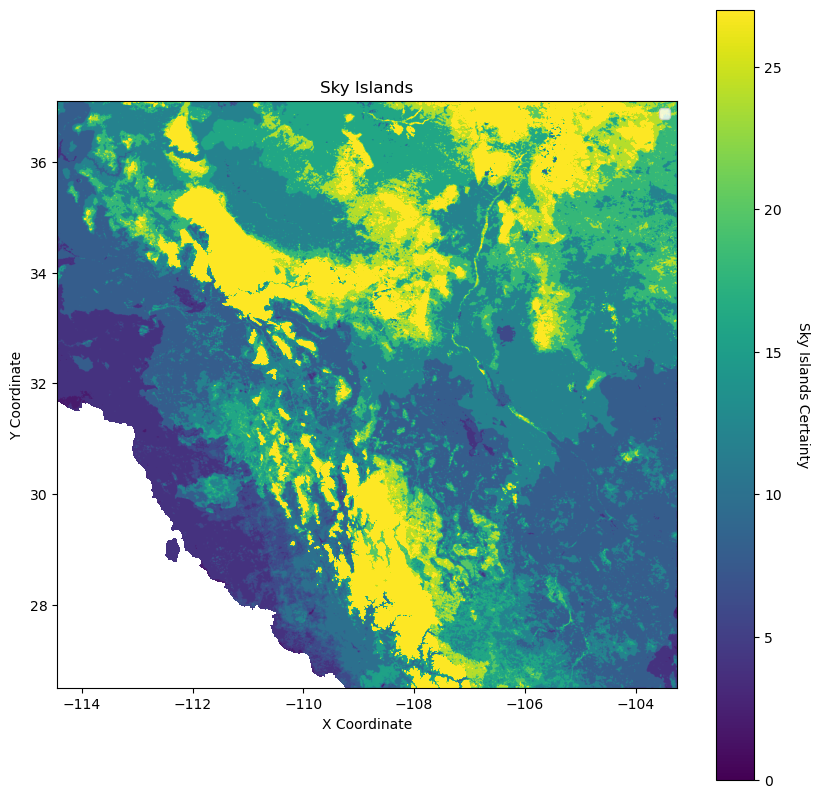

In [15]:
# Set variables for the band being used and set the transformation
skyIslands = rasterio.open('siRast.tif')
rasterData = skyIslands.read(1)
rasterTransform = skyIslands.transform

# Define normalization based on the range of siRaster
norm = Normalize(vmin=0, vmax=27)

# Plot the raster with rasterio's show function
fig, ax = plt.subplots(figsize=(10, 10))
raster_plot = ax.imshow(siRaster, cmap='viridis', extent=(
    rasterTransform[2],  # xmin
    rasterTransform[2] + rasterTransform[0] * rasterData.shape[1],  # xmax
    rasterTransform[5] + rasterTransform[4] * rasterData.shape[0],  # ymin
    rasterTransform[5]  # ymax
), vmin = 0, vmax = 27)

# Add the colorbar based on the raster plot
cbar = fig.colorbar(raster_plot, ax=ax, norm=norm)
cbar.set_label('Sky Islands Certainty', rotation=270, labelpad=20)

# Overlay the points on the raster basemap
#siAberts.plot(ax=ax, marker='o', color='red', markersize=10, label="Abert's Squirrel Occurrence")

# Add labels, legend, and title
ax.set_title('Sky Islands')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

ax.legend()

# Save the figure
plt.savefig('Sky Islands Model.png', dpi = 300, bbox_inches = 'tight')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


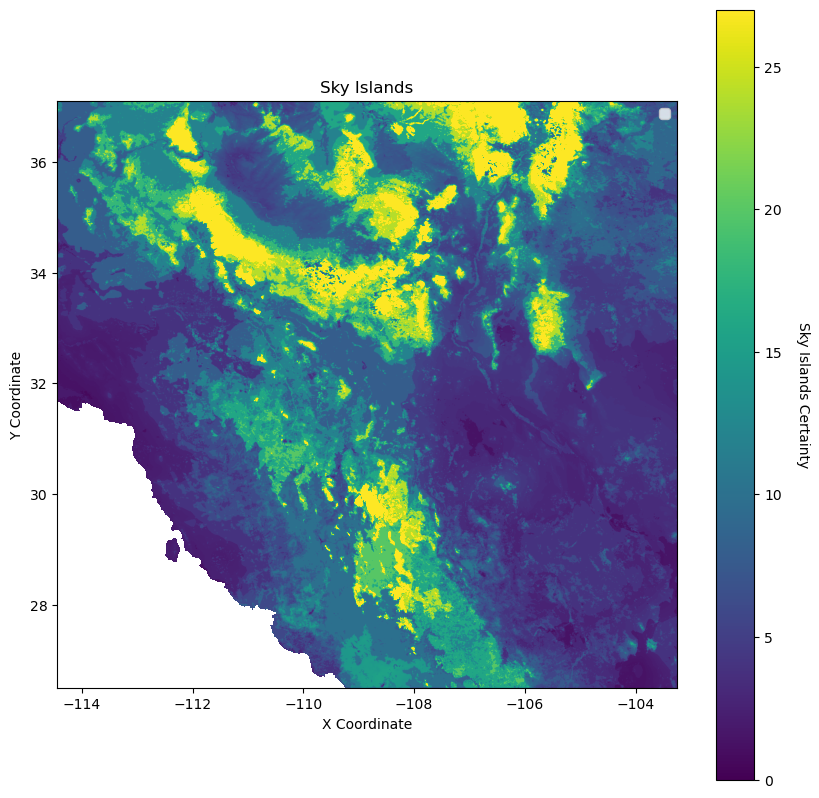

In [6]:
# Set variables for the band being used and set the transformation
skyIslands = rasterio.open('siRast_50years.tif')
rasterData = skyIslands.read(1)
rasterTransform = skyIslands.transform

# Define normalization based on the range of siRaster
norm = Normalize(vmin=0, vmax=27)

# Plot the raster with rasterio's show function
fig, ax = plt.subplots(figsize=(10, 10))
raster_plot = ax.imshow(siRaster, cmap='viridis', extent=(
    rasterTransform[2],  # xmin
    rasterTransform[2] + rasterTransform[0] * rasterData.shape[1],  # xmax
    rasterTransform[5] + rasterTransform[4] * rasterData.shape[0],  # ymin
    rasterTransform[5]  # ymax
), vmin = 0, vmax = 27)

# Add the colorbar based on the raster plot
cbar = fig.colorbar(raster_plot, ax=ax, norm=norm)
cbar.set_label('Sky Islands Certainty', rotation=270, labelpad=20)

# Overlay the points on the raster basemap
#siAberts.plot(ax=ax, marker='o', color='red', markersize=10, label="Abert's Squirrel Occurrence")

# Add labels, legend, and title
ax.set_title('Sky Islands')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

ax.legend()

# Save the figure
plt.savefig('Sky Islands Model 50 Years.png', dpi = 300, bbox_inches = 'tight')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


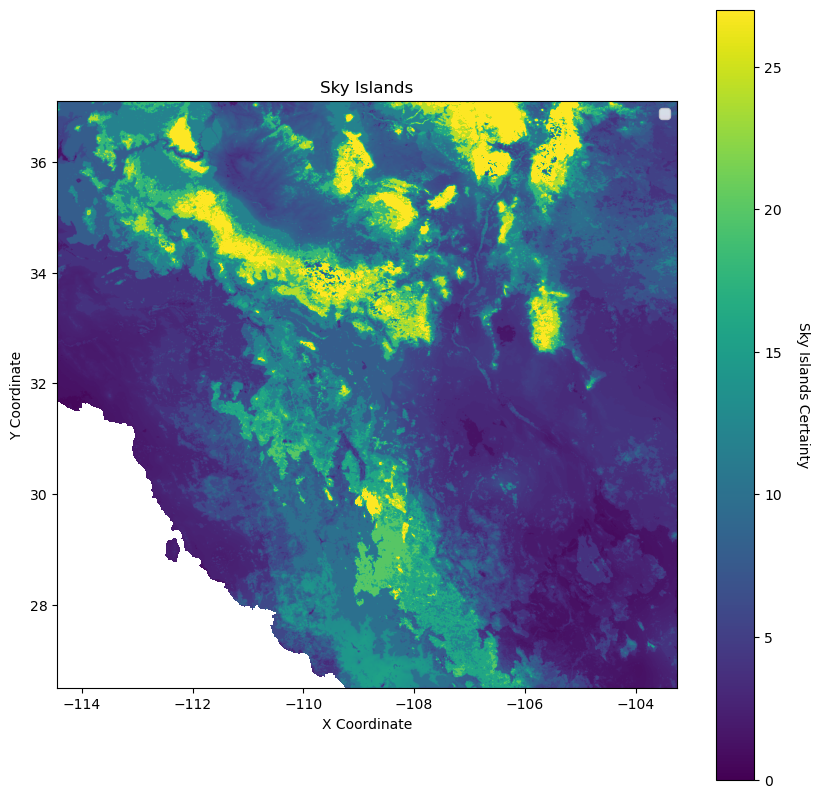

In [9]:
# Set variables for the band being used and set the transformation
skyIslands = rasterio.open('siRast_100years.tif')
rasterData = skyIslands.read(1)
rasterTransform = skyIslands.transform

# Define normalization based on the range of siRaster
norm = Normalize(vmin=0, vmax=27)

# Plot the raster with rasterio's show function
fig, ax = plt.subplots(figsize=(10, 10))
raster_plot = ax.imshow(siRaster, cmap='viridis', extent=(
    rasterTransform[2],  # xmin
    rasterTransform[2] + rasterTransform[0] * rasterData.shape[1],  # xmax
    rasterTransform[5] + rasterTransform[4] * rasterData.shape[0],  # ymin
    rasterTransform[5]  # ymax
), vmin = 0, vmax = 27)

# Add the colorbar based on the raster plot
cbar = fig.colorbar(raster_plot, ax=ax, norm=norm)
cbar.set_label('Sky Islands Certainty', rotation=270, labelpad=20)

# Overlay the points on the raster basemap
#siAberts.plot(ax=ax, marker='o', color='red', markersize=10, label="Abert's Squirrel Occurrence")

# Add labels, legend, and title
ax.set_title('Sky Islands')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

ax.legend()

# Save the figure
plt.savefig('Sky Islands Model 100 Years.png', dpi = 300, bbox_inches = 'tight')

plt.show()

### Accuracy assessment preparation functions

- numTrue() - Finds the number of points with a raster value above a certain threshold (

In [20]:
# Create a function which extracts raster values to a point GDF
def numTrue(rasterPath, ptsGDF, threshold):

    # Open the raster to extract values from
    with rasterio.open(rasterPath) as src:

        # Create a coord_list variable
        coords = [(x, y) for x, y in zip(ptsGDF['geometry'].x, ptsGDF['geometry'].y)]

        # Add values into GDF
        ptsGDF['value'] = [x for x in src.sample(coords)]

        # Create a list with values
        valList = ptsGDF['value'].tolist()
        
    # Set numTrue variable to 0
    numTrue = 0

    # Add 1 for each value at or above user-defined threshold
    for vals in valList:
        if vals >= threshold:
            numTrue += 1

    # Return the number of true points
    return valList, numTrue

## Perform Accuracy Assessment (T-test/p-value)

- Sky islands are depicted as areas within the siRast.tif raster >= 18
    - A cell in the NDVI, temperature, or precipitation rasters reclassified to 3 means it reaches the minimum of that parameter for a sky island
    - 2 is considered nearly necessary and 4 is considered just beyond necessary
    - At a raster value of 18, 2 parameters are at the minimum required value and 1 parameter is near the minimum required value

In [152]:
def siAccAssessment_tTest(raster,speciesPts,studyArea,stepNum):
    
    start = time.time()

    # Create an empty list to add lists to at the end
    bplotList = []
    
    # Find number of points in the speciesPts to create the same number of random points
    total_rand_pts = 0
    for index, row in speciesPts.iterrows():
        total_rand_pts += 1
    
    # Find number of points greater than or equal to 8 function on species points
    specList, numSpec_true = numTrue(raster,speciesPts,9)

    # Append specList to bplotList
    bplotList.append(specList)
            
    print(f"Number of species' occurrences within a sky island: {numSpec_true}.")

    # Create empty list to add the number of random points within a sky island to
    randPt_list = []
    
    # Run the assessment a user-defined number of times
    for i in range(0,stepNum):
                
        # Create random points
        randPts = genRandPts(studyArea,total_rand_pts)

        # Add raster values to points
        randList, numRand_true = numTrue(raster,randPts,9)

        # Add all random points within a sky island to a list
        randPt_list.append(numRand_true)
                
        # Print num_true value for each step
        print(f'Run: {i} - randPts: {numRand_true}')

        # Remove what is in the randPts variable
        randPts = None

        # Append randList to bplotList
        bplotList.append(randList)
                
    # Find t-test value and p-value
    tTestVal, pValue = stats.ttest_1samp(randPt_list,numSpec_true)
    
    # Print t-test value and p-value
    print(f'T-statistic: {tTestVal}')
    print(f'P-value: {pValue}')
    print('')

    # Return data for boxplot
    bplotData = [[val.item() for val in sublist] for sublist in bplotList]

    return bplotData
    
    end = time.time()
    
    processing_time = end - start
    
    exe_time = str(timedelta(seconds = processing_time))
    
    print(f'Function execution time: {exe_time}')

In [153]:
bplotData = siAccAssessment_tTest(
    raster = 'siRast.tif',
    speciesPts = siAberts,
    studyArea = siBoundary,
    stepNum = 10
)

Number of species' occurrences within a sky island: 1840.
Run: 0 - randPts: 258
Run: 1 - randPts: 261
Run: 2 - randPts: 254
Run: 3 - randPts: 260
Run: 4 - randPts: 252
Run: 5 - randPts: 247
Run: 6 - randPts: 261
Run: 7 - randPts: 274
Run: 8 - randPts: 259
Run: 9 - randPts: 261
T-statistic: -702.4339432568257
P-value: 1.2228945768073708e-22



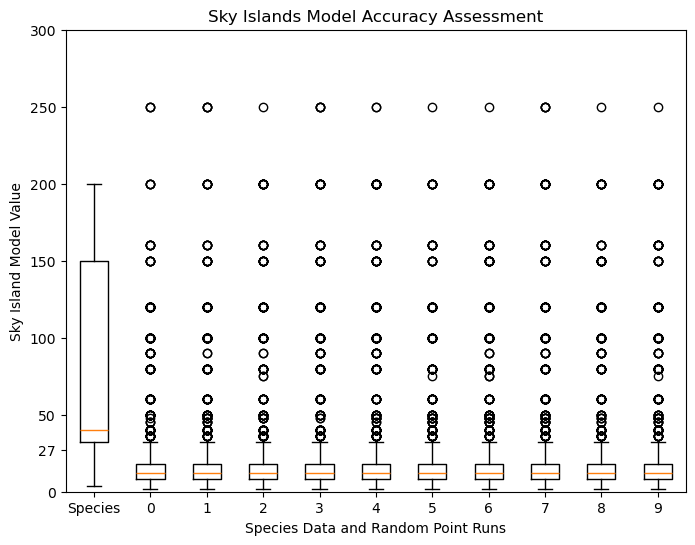

In [163]:
# Create figure with axis
fig, ax = plt.subplots(figsize=(8,6))

# Create a boxplot
ax.boxplot(bplotData)

# Set the labels for each boxplot
bplotLabels = [
    'Species',
    '0',
    '1',
    '2',
    '3',
    '4',
    '5',
    '6',
    '7',
    '8',
    '9'
]

# Add labels in the correct order
ax.set_xticks([i + 1 for i in range(len(bplotLabels))])

# Set the labels
ax.set_xticklabels(bplotLabels)

# Set minimum y-axis value to 0
ax.set_ylim(bottom = 0)

# Set plot title and axis titles
ax.set_title('Sky Islands Model Accuracy Assessment')
ax.set_xlabel('Species Data and Random Point Runs')
ax.set_ylabel('Sky Island Model Value')

# Add a tick mark at 27 on the y-axis
y_ticks = ax.get_yticks().tolist()  # Get existing ticks

# Add 27 to the list of ticks
y_ticks.append(27)

# Set the updated list of ticks, sorted for neatness
ax.set_yticks(sorted(y_ticks))

# Save the plot
plt.savefig('Accuracy Assessment Boxplots.png', dpi = 300, bbox_inches = 'tight')

# Show the plot
plt.show()

## Success

The MVP is successful if I create a SI raster where the number of Abert’s Squirrel observations found within SIs are significantly different from random points found in SIs. SIs do not have discrete boundaries, but it is known Abert’s Squirrels use them as their habitat in the southwestern United States and northern Mexico, so if there are far more Abert’s Squirrels within SIs than randomly placed points in this region, it is likely the created SI raster is accurate


## Reflection

While my MVP was successful, showing an extreme T-statistic value (-316.4) and very low p-value (1.6e-19), I have to be honest and say I am not very happy with the code itself. I believe there are too many functions for rasters, as I had a lot of trouble aligning the rasters since the NDVI rasters needed to be merged together (United States and Mexico data) and the NDVI rasters (eVIIRS) and temperature and precipitation (WorldClim) rasters had different spatial resolutions. Additionally, due to the study area being fairly large, it was difficult to use rasters with a high spatial resolution, so the final SI raster has a relatively low spatial resolution. 

I learned more about the rasterio library throughout this MVP, which has always been a module I was less familiar with, as most of my previous projects with Jupyter Notebooks utilize vector data. I am more familiar with using raster data with Arcpy, so creating functions for raster calculators, resampling, and reclassifying was relatively new. I hope I can use what I learned within this MVP moving forward to limit the size of my Jupyter Notebook moving forward. 

I would have practiced more with the rasterio library before taking on this task of creating a SI raster. This MVP is essentially setup for the IBM moving forward, but the IBM base has actually already been created and creating the SI model took much more time than previously expected. I now understand how to progress and I do have code for creating various raster functions moving forward.